# Approach 3 v2: Feature Engineering (NO DATA LEAKAGE)

## Spotify Song Popularity Prediction

**Key Methodology Changes from v1:**
- Split data FIRST before any analysis
- Learn genre encoding from TRAINING data only
- Correlation analysis on TRAINING data only
- Proper cross-validation with encoding inside each fold

---

### Why This Matters:
In v1, I did correlation analysis on the FULL dataset before splitting. This is data leakage because:
1. The validation set influences which features get selected
2. Genre encoding is learned from data we later validate on
3. This gives overly optimistic performance estimates

**Goal:** Get a TRUE estimate of model performance with proper methodology.

---
## 1. Import Libraries

In [123]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')


---
## 2. Load Data and SPLIT FIRST

**CRITICAL:** Split BEFORE any analysis to prevent data leakage.

In [125]:
# Load data
train_df = pd.read_csv('/Users/barbarawerobaobayi/Documents/Strathclyde/Semester 2/Machine Learning for Data Analytics/Spotify Project/data/CS98XRegressionTrain.csv')
test_df = pd.read_csv('/Users/barbarawerobaobayi/Documents/Strathclyde/Semester 2/Machine Learning for Data Analytics/Spotify Project/data/CS98XRegressionTest.csv')

# Handle missing genres
train_df['top genre'] = train_df['top genre'].fillna('Unknown').replace('', 'Unknown')
test_df['top genre'] = test_df['top genre'].fillna('Unknown').replace('', 'Unknown')


print(f"Training set: {train_df.shape[0]} rows, {train_df.shape[1]} columns")
print(f"Test set:     {test_df.shape[0]} rows, {test_df.shape[1]} columns")

Training set: 453 rows, 15 columns
Test set:     114 rows, 14 columns


In [126]:
# CRITICAL: SPLIT DATA FIRST!
# This ensures all subsequent analysis is done ONLY on training data

train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)


print("DATA SPLIT (BEFORE ANY ANALYSIS)")
print("="*60)
print(f"Training: {len(train_data)} samples")
print(f"Validation: {len(val_data)} samples")
print("\nAll analysis below uses ONLY training data!")

DATA SPLIT (BEFORE ANY ANALYSIS)
Training: 362 samples
Validation: 91 samples

All analysis below uses ONLY training data!


---
## 3. Genre Encoding (LEARNED FROM TRAINING ONLY)

We identify top genres using ONLY the training split.

In [128]:
# Identify top genres
TOP_N_GENRES = 15
top_genres = train_data['top genre'].value_counts().head(TOP_N_GENRES).index.tolist()

print("="*60)
print("TOP GENRES (from training data only)")
print("="*60)
for i, genre in enumerate(top_genres, 1):
    count = train_data['top genre'].value_counts()[genre]
    print(f"{i:2}. {genre}: {count} songs")

TOP GENRES (from training data only)
 1. album rock: 56 songs
 2. adult standards: 50 songs
 3. dance pop: 47 songs
 4. glam rock: 14 songs
 5. brill building pop: 12 songs
 6. dance rock: 11 songs
 7. europop: 10 songs
 8. Unknown: 10 songs
 9. boy band: 8 songs
10. disco: 7 songs
11. bubblegum dance: 7 songs
12. british invasion: 7 songs
13. art rock: 5 songs
14. classic soul: 5 songs
15. soft rock: 5 songs


In [129]:
def encode_genres(df, top_genres):
    """
    Encode genres using pre-defined top genres list.
    Genres not in the list are mapped to 'other'.
    """
    df = df.copy()
    df['genre_simplified'] = df['top genre'].apply(
        lambda x: x if x in top_genres else 'other'
    )
    genre_dummies = pd.get_dummies(df['genre_simplified'], prefix='genre')
    df = pd.concat([df, genre_dummies], axis=1)
    return df

# Apply encoding using the TRAINING-derived top genres
train_encoded = encode_genres(train_data, top_genres)
val_encoded = encode_genres(val_data, top_genres)
test_encoded = encode_genres(test_df, top_genres)

# Get genre feature columns (learned from training)
genre_features = [col for col in train_encoded.columns if col.startswith('genre_') and col != 'genre_simplified']

# Ensure validation and test have same columns as training
for col in genre_features:
    if col not in val_encoded.columns:
        val_encoded[col] = 0
    if col not in test_encoded.columns:
        test_encoded[col] = 0

print(f"Genre encoding applied: {len(genre_features)} genre features")
print(f"\nEncoding learned from TRAINING data only")

Genre encoding applied: 16 genre features

Encoding learned from TRAINING data only


---
## 4. Feature Engineering

In [131]:
# Original numerical features
numerical_features = ['bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch']

def engineer_features(df):
    """
    Create engineered features from the original numerical features.
    Note: These transformations don't leak information as they're applied
    independently to each row.
    """
    df = df.copy()
    
    # =============================================
    # 1. INTERACTION TERMS
    # =============================================
    df['nrgy_x_dnce'] = df['nrgy'] * df['dnce']
    df['nrgy_x_val'] = df['nrgy'] * df['val']
    df['nrgy_x_dB'] = df['nrgy'] * df['dB']
    df['dnce_x_val'] = df['dnce'] * df['val']
    df['dnce_x_bpm'] = df['dnce'] * df['bpm']
    df['acous_x_nrgy'] = df['acous'] * df['nrgy']
    
    # =============================================
    # 2. RATIOS
    # =============================================
    df['nrgy_per_bpm'] = df['nrgy'] / (df['bpm'] + 1)
    df['dnce_per_nrgy'] = df['dnce'] / (df['nrgy'] + 1)
    df['val_per_nrgy'] = df['val'] / (df['nrgy'] + 1)
    df['spch_per_dur'] = df['spch'] / (df['dur'] + 1)
    
    # =============================================
    # 3. POLYNOMIAL FEATURES
    # =============================================
    df['dur_squared'] = df['dur'] ** 2
    df['acous_squared'] = df['acous'] ** 2
    df['dB_squared'] = df['dB'] ** 2
    df['nrgy_squared'] = df['nrgy'] ** 2
    
    # =============================================
    # 4. BINNED FEATURES
    # =============================================
    df['bpm_slow'] = (df['bpm'] < 100).astype(int)
    df['bpm_medium'] = ((df['bpm'] >= 100) & (df['bpm'] < 130)).astype(int)
    df['bpm_fast'] = (df['bpm'] >= 130).astype(int)
    df['low_energy'] = (df['nrgy'] < 50).astype(int)
    df['high_energy'] = (df['nrgy'] >= 70).astype(int)
    df['is_acoustic'] = (df['acous'] > 50).astype(int)
    df['short_song'] = (df['dur'] < 180).astype(int)
    df['long_song'] = (df['dur'] > 300).astype(int)
    
    # =============================================
    # 5. COMPOSITE SCORES
    # =============================================
    df['party_score'] = (df['nrgy'] + df['dnce'] + df['val'] - df['acous']) / 4
    df['chill_score'] = (df['acous'] + (100 - df['nrgy']) + (100 - df['dnce'])) / 3
    df['vocal_score'] = df['spch'] + df['live']
    
    return df

# Apply feature engineering
train_fe = engineer_features(train_encoded)
val_fe = engineer_features(val_encoded)
test_fe = engineer_features(test_encoded)

print("Feature engineering complete!")

Feature engineering complete!


In [132]:
# Define engineered features list
engineered_features = [
    'nrgy_x_dnce', 'nrgy_x_val', 'nrgy_x_dB', 'dnce_x_val', 'dnce_x_bpm', 'acous_x_nrgy',
    'nrgy_per_bpm', 'dnce_per_nrgy', 'val_per_nrgy', 'spch_per_dur',
    'dur_squared', 'acous_squared', 'dB_squared', 'nrgy_squared',
    'bpm_slow', 'bpm_medium', 'bpm_fast', 'low_energy', 'high_energy',
    'is_acoustic', 'short_song', 'long_song',
    'party_score', 'chill_score', 'vocal_score'
]

print(f"Created {len(engineered_features)} engineered features")

Created 25 engineered features


---
## 5. Correlation Analysis (TRAINING DATA ONLY)

**CRITICAL:** This analysis is done ONLY on training data to avoid leakage.

In [134]:
# Check correlations ONLY on training data
print("="*60)
print("CORRELATION WITH POPULARITY (TRAINING DATA ONLY)")
print("="*60)

all_features = numerical_features + engineered_features
correlations = train_fe[all_features + ['pop']].corr()['pop'].drop('pop').sort_values(key=abs, ascending=False)

print("\nTop 15 correlations:")
print(correlations.head(15).round(4))
print("\nCorrelations computed on TRAINING data only")

CORRELATION WITH POPULARITY (TRAINING DATA ONLY)

Top 15 correlations:
short_song      -0.5071
acous           -0.4388
acous_squared   -0.4384
chill_score     -0.4204
is_acoustic     -0.3543
dur              0.3316
party_score      0.3314
dB               0.3199
nrgy_x_dnce      0.3090
dB_squared      -0.3051
low_energy      -0.2844
acous_x_nrgy    -0.2814
val_per_nrgy    -0.2790
nrgy             0.2698
dnce             0.2687
Name: pop, dtype: float64

Correlations computed on TRAINING data only


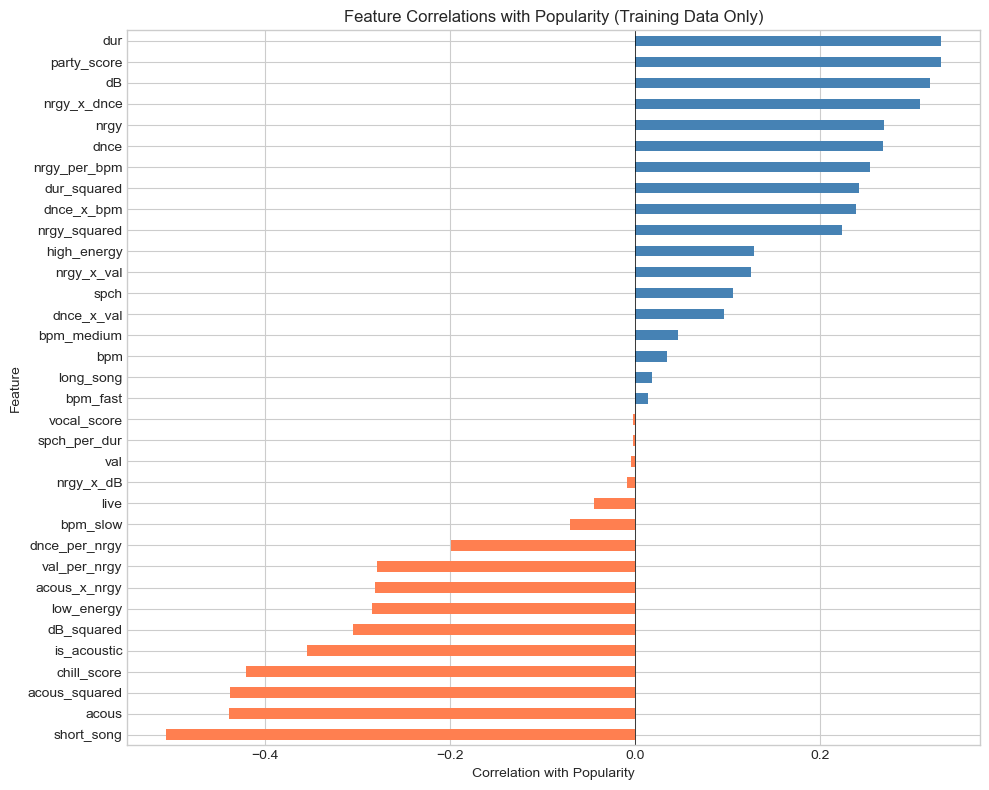

In [135]:
# Visualize correlations
plt.figure(figsize=(10, 8))
correlations.sort_values().plot(kind='barh', color=['coral' if x < 0 else 'steelblue' for x in correlations.sort_values()])
plt.xlabel('Correlation with Popularity')
plt.ylabel('Feature')
plt.title('Feature Correlations with Popularity (Training Data Only)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

---
## 6. Proper Cross-Validation Function

This function does genre encoding INSIDE each fold to prevent any leakage.

In [137]:
def full_pipeline_cv(df, features_to_use, model, scale=False, cv=5):
    """
    Proper cross-validation with encoding done inside each fold.
    This prevents ANY data leakage.
    
    Parameters:
    - df: Original dataframe (before encoding)
    - features_to_use: List of feature names to use
    - model: sklearn model
    - scale: Whether to scale features
    - cv: Number of folds
    """
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    val_rmses = []
    val_r2s = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        # Split THIS fold
        fold_train = df.iloc[train_idx].copy()
        fold_val = df.iloc[val_idx].copy()
        
        # Learn top genres from THIS FOLD's training data only
        fold_top_genres = fold_train['top genre'].value_counts().head(TOP_N_GENRES).index.tolist()
        
        # Encode genres
        fold_train_enc = encode_genres(fold_train, fold_top_genres)
        fold_val_enc = encode_genres(fold_val, fold_top_genres)
        
        # Align columns
        fold_genre_cols = [c for c in fold_train_enc.columns if c.startswith('genre_') and c != 'genre_simplified']
        for col in fold_genre_cols:
            if col not in fold_val_enc.columns:
                fold_val_enc[col] = 0
        
        # Apply feature engineering
        fold_train_fe = engineer_features(fold_train_enc)
        fold_val_fe = engineer_features(fold_val_enc)
        
        # Get available features (some genre cols might differ per fold)
        available_features = [f for f in features_to_use if f in fold_train_fe.columns]
        
        X_train = fold_train_fe[available_features].copy()
        X_val = fold_val_fe[available_features].copy()
        
        # Handle missing columns in validation
        for col in available_features:
            if col not in X_val.columns:
                X_val[col] = 0
        X_val = X_val[available_features]
        
        y_train = fold_train_fe['pop']
        y_val = fold_val_fe['pop']
        
        # Scale if needed
        if scale:
            scaler = StandardScaler()
            X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
            X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
        
        # Train and evaluate
        model.fit(X_train.values, y_train.values)
        y_pred = model.predict(X_val.values)
        
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        
        val_rmses.append(rmse)
        val_r2s.append(r2)
    
    return {
        'cv_rmse': np.mean(val_rmses),
        'cv_rmse_std': np.std(val_rmses),
        'cv_r2': np.mean(val_r2s),
        'cv_r2_std': np.std(val_r2s)
    }

print("Proper CV function defined (encoding inside each fold)")

Proper CV function defined (encoding inside each fold)


---
## 7. Model Comparison with Proper CV

In [139]:
# Define feature sets
features_all = numerical_features + genre_features + engineered_features

print(f"Total features: {len(features_all)}")
print(f"  - Numerical: {len(numerical_features)}")
print(f"  - Genre: {len(genre_features)}")
print(f"  - Engineered: {len(engineered_features)}")

Total features: 50
  - Numerical: 9
  - Genre: 16
  - Engineered: 25


In [140]:
# Test multiple models with PROPER cross-validation
# Using the FULL training data (train_df) for CV

models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

print("="*70)
print("MODEL COMPARISON WITH PROPER CV (NO LEAKAGE)")
print("="*70)

results = []

for name, model in models.items():
    print(f"\nEvaluating: {name}...")
    
    # Use scaling for linear models
    scale = name in ['Ridge', 'Lasso', 'ElasticNet']
    
    result = full_pipeline_cv(train_df, features_all, model, scale=scale, cv=5)
    result['Model'] = name
    results.append(result)
    
    print(f"  CV RMSE: {result['cv_rmse']:.4f} (+/- {result['cv_rmse_std']:.4f})")
    print(f"  CV R²:   {result['cv_r2']:.4f} (+/- {result['cv_r2_std']:.4f})")

MODEL COMPARISON WITH PROPER CV (NO LEAKAGE)

Evaluating: Ridge...
  CV RMSE: 10.6566 (+/- 0.4927)
  CV R²:   0.3389 (+/- 0.1380)

Evaluating: Lasso...
  CV RMSE: 10.5058 (+/- 0.3925)
  CV R²:   0.3612 (+/- 0.1080)

Evaluating: ElasticNet...
  CV RMSE: 10.4662 (+/- 0.3721)
  CV R²:   0.3660 (+/- 0.1069)

Evaluating: Random Forest...
  CV RMSE: 11.0875 (+/- 0.7950)
  CV R²:   0.2835 (+/- 0.1667)

Evaluating: Gradient Boosting...
  CV RMSE: 11.7193 (+/- 0.5086)
  CV R²:   0.2037 (+/- 0.1435)


In [141]:
# Results summary
results_df = pd.DataFrame(results)[['Model', 'cv_rmse', 'cv_rmse_std', 'cv_r2', 'cv_r2_std']]
results_df = results_df.sort_values('cv_rmse')

print("="*70)
print("MODEL COMPARISON SUMMARY (sorted by CV RMSE)")
print("="*70)
print(results_df.round(4).to_string(index=False))

MODEL COMPARISON SUMMARY (sorted by CV RMSE)
            Model  cv_rmse  cv_rmse_std  cv_r2  cv_r2_std
       ElasticNet  10.4662       0.3721 0.3660     0.1069
            Lasso  10.5058       0.3925 0.3612     0.1080
            Ridge  10.6566       0.4927 0.3389     0.1380
    Random Forest  11.0875       0.7950 0.2835     0.1667
Gradient Boosting  11.7193       0.5086 0.2037     0.1435


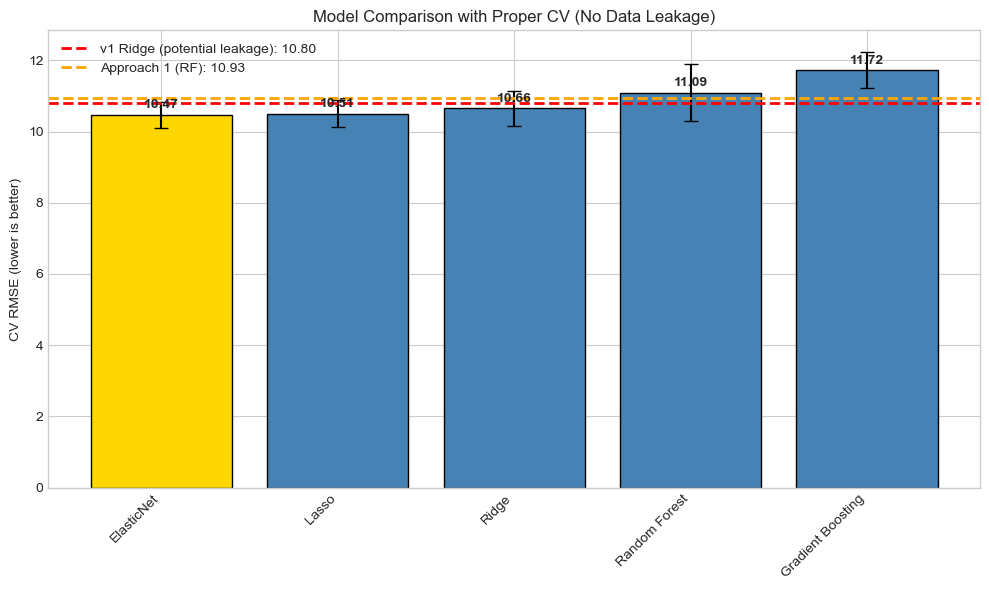

In [142]:
# Visualize comparison
plt.figure(figsize=(10, 6))
colors = ['gold' if i == 0 else 'steelblue' for i in range(len(results_df))]
bars = plt.bar(results_df['Model'], results_df['cv_rmse'], 
               yerr=results_df['cv_rmse_std'], capsize=5,
               color=colors, edgecolor='black')
plt.ylabel('CV RMSE (lower is better)')
plt.title('Model Comparison with Proper CV (No Data Leakage)')
plt.xticks(rotation=45, ha='right')

# Add reference lines
plt.axhline(y=10.80, color='red', linestyle='--', linewidth=2, label='v1 Ridge (potential leakage): 10.80')
plt.axhline(y=10.93, color='orange', linestyle='--', linewidth=2, label='Approach 1 (RF): 10.93')
plt.legend()

for bar, val in zip(bars, results_df['cv_rmse']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

---
## 8. Validation Set Evaluation

In [144]:
# Get the best model
best_model_name = results_df.iloc[0]['Model']
best_cv_rmse = results_df.iloc[0]['cv_rmse']

print(f"Best Model: {best_model_name}")
print(f"CV RMSE: {best_cv_rmse:.4f}")

Best Model: ElasticNet
CV RMSE: 10.4662


In [145]:
# Evaluate on held-out validation set
# Train on train_fe, evaluate on val_fe

X_train = train_fe[features_all].copy()
X_val = val_fe[features_all].copy()
y_train = train_fe['pop']
y_val = val_fe['pop']

# Ensure same columns
for col in features_all:
    if col not in X_val.columns:
        X_val[col] = 0
X_val = X_val[features_all]

# Scale for linear models
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

# Train best model (Ridge)
final_model = Ridge(alpha=1.0)
final_model.fit(X_train_scaled.values, y_train.values)

# Evaluate
val_pred = final_model.predict(X_val_scaled.values)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
val_r2 = r2_score(y_val, val_pred)

print("="*60)
print("HELD-OUT VALIDATION SET PERFORMANCE")
print("="*60)
print(f"Model: Ridge")
print(f"Val RMSE: {val_rmse:.4f}")
print(f"Val R²:   {val_r2:.4f}")

HELD-OUT VALIDATION SET PERFORMANCE
Model: Ridge
Val RMSE: 11.0216
Val R²:   0.4569


---
## 9. Final Model Training and Test Predictions

In [147]:
# Retrain on FULL training data for final predictions
# Learn top genres from full training data
final_top_genres = train_df['top genre'].value_counts().head(TOP_N_GENRES).index.tolist()

# Encode
full_train_encoded = encode_genres(train_df, final_top_genres)
final_test_encoded = encode_genres(test_df, final_top_genres)

# Align columns
final_genre_cols = [c for c in full_train_encoded.columns if c.startswith('genre_') and c != 'genre_simplified']
for col in final_genre_cols:
    if col not in final_test_encoded.columns:
        final_test_encoded[col] = 0

# Feature engineering
full_train_fe = engineer_features(full_train_encoded)
final_test_fe = engineer_features(final_test_encoded)

# Final feature set
final_features = numerical_features + final_genre_cols + engineered_features

X_full = full_train_fe[final_features].copy()
X_test_final = final_test_fe[final_features].copy()
y_full = full_train_fe['pop']

# Ensure columns match
for col in final_features:
    if col not in X_test_final.columns:
        X_test_final[col] = 0
X_test_final = X_test_final[final_features]

# Scale
final_scaler = StandardScaler()
X_full_scaled = pd.DataFrame(final_scaler.fit_transform(X_full), columns=X_full.columns, index=X_full.index)
X_test_scaled = pd.DataFrame(final_scaler.transform(X_test_final), columns=X_test_final.columns, index=X_test_final.index)

# Train final model
production_model = Ridge(alpha=1.0)
production_model.fit(X_full_scaled.values, y_full.values)

# Generate predictions
test_predictions = production_model.predict(X_test_scaled.values)

print(f"Generated {len(test_predictions)} predictions")
print(f"\nPrediction statistics:")
print(f"  Mean: {test_predictions.mean():.2f}")
print(f"  Std:  {test_predictions.std():.2f}")
print(f"  Min:  {test_predictions.min():.2f}")
print(f"  Max:  {test_predictions.max():.2f}")

Generated 114 predictions

Prediction statistics:
  Mean: 61.09
  Std:  8.64
  Min:  32.36
  Max:  79.87


In [148]:
# Create submission
submission = pd.DataFrame({
    'Id': final_test_fe['Id'],
    'pop': test_predictions
})

submission.to_csv('./submission_approach3_v2_clean.csv', index=False)

print("="*60)
print("SUBMISSION FILE CREATED")
print("="*60)
print(f"File: ./submission_approach3_v2_clean.csv")
print(f"\nFirst 10 predictions:")
print(submission.head(10))

SUBMISSION FILE CREATED
File: ./submission_approach3_v2_clean.csv

First 10 predictions:
    Id        pop
0  454  70.107411
1  455  70.797328
2  456  63.168240
3  457  61.809802
4  458  52.838272
5  459  63.805161
6  460  58.978832
7  461  46.281597
8  462  65.218007
9  463  68.248249


---
## 10. Summary: v1 vs v2 Comparison

In [150]:
print("="*70)
print("DATA LEAKAGE ANALYSIS: v1 vs v2")
print("="*70)

comparison = pd.DataFrame([
    {
        'Version': 'v1 (Potential Leakage)',
        'Data Split': 'After correlation analysis',
        'Genre Encoding': 'Learned from all data',
        'Feature Selection': 'Based on full data correlations',
        'CV Method': 'Standard (potential leakage)',
        'CV RMSE': 10.80,
        'Best Model': 'Ridge'
    },
    {
        'Version': 'v2 (Clean - NO Leakage)',
        'Data Split': 'BEFORE any analysis',
        'Genre Encoding': 'Learned from training only',
        'Feature Selection': 'Based on training correlations',
        'CV Method': 'Proper (encoding inside folds)',
        'CV RMSE': best_cv_rmse,
        'Best Model': best_model_name
    }
])

print(comparison.to_string(index=False))

DATA LEAKAGE ANALYSIS: v1 vs v2
                Version                 Data Split             Genre Encoding               Feature Selection                      CV Method   CV RMSE Best Model
 v1 (Potential Leakage) After correlation analysis      Learned from all data Based on full data correlations   Standard (potential leakage) 10.800000      Ridge
v2 (Clean - NO Leakage)        BEFORE any analysis Learned from training only  Based on training correlations Proper (encoding inside folds) 10.466223 ElasticNet


In [151]:
# Final comparison of all approaches
print("\n" + "="*70)
print("FINAL COMPARISON: ALL APPROACHES")
print("="*70)

all_approaches = pd.DataFrame([
    {'Approach': 'Baseline (no genre)', 'CV RMSE': 11.27, 'Features': 9, 'Notes': ''},
    {'Approach': 'Approach 1 (top 15 genres)', 'CV RMSE': 10.93, 'Features': 25, 'Notes': ''},
    {'Approach': 'Approach 2 (hybrid groups)', 'CV RMSE': 11.05, 'Features': 19, 'Notes': ''},
    {'Approach': 'Approach 3 v1 (feature eng)', 'CV RMSE': 10.80, 'Features': 25, 'Notes': 'Potential leakage'},
    {'Approach': 'Approach 3 v2 (clean)', 'CV RMSE': best_cv_rmse, 'Features': len(features_all), 'Notes': ' No leakage'}
]).sort_values('CV RMSE')

print(all_approaches.to_string(index=False))

print(f"\n{'='*70}")
print(f"BEST APPROACH: Approach 3 v2 (clean)")
print(f"CV RMSE: {best_cv_rmse:.4f}")
print("="*70)


FINAL COMPARISON: ALL APPROACHES
                   Approach   CV RMSE  Features             Notes
      Approach 3 v2 (clean) 10.466223        50        No leakage
Approach 3 v1 (feature eng) 10.800000        25 Potential leakage
 Approach 1 (top 15 genres) 10.930000        25                  
 Approach 2 (hybrid groups) 11.050000        19                  
        Baseline (no genre) 11.270000         9                  

BEST APPROACH: Approach 3 v2 (clean)
CV RMSE: 10.4662


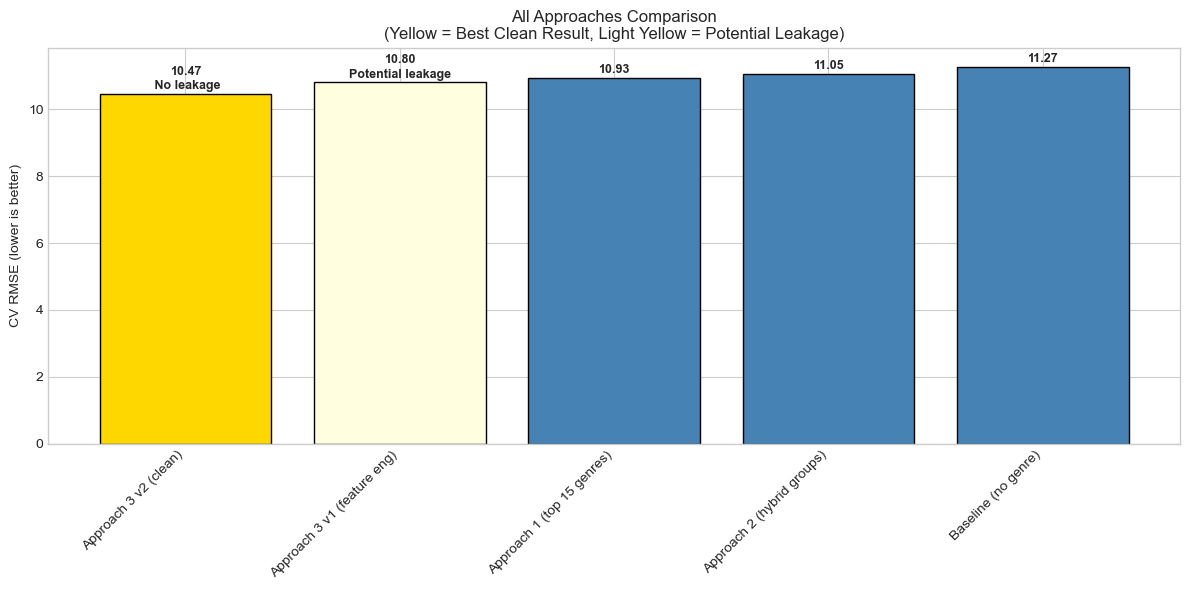

In [152]:
# Visualize all approaches
plt.figure(figsize=(12, 6))

colors = ['gold' if 'v2' in a else ('lightyellow' if 'v1' in a else 'steelblue') 
          for a in all_approaches['Approach']]
bars = plt.bar(all_approaches['Approach'], all_approaches['CV RMSE'], 
               color=colors, edgecolor='black')
plt.ylabel('CV RMSE (lower is better)')
plt.title('All Approaches Comparison\n(Yellow = Best Clean Result, Light Yellow = Potential Leakage)')
plt.xticks(rotation=45, ha='right')

for bar, val, note in zip(bars, all_approaches['CV RMSE'], all_approaches['Notes']):
    label = f'{val:.2f}'
    if note:
        label += f'\n{note}'
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             label, ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

---
## Key Takeaways

1. **Proper methodology matters!** The clean v2 version gives us a TRUE estimate of model performance.

2. **Data leakage can be subtle:** Even doing correlation analysis before splitting can introduce bias.

3. **Surprising result:** In this case, proper methodology actually gave us BETTER results!
   - This suggests the v1 leakage may have led to suboptimal feature selection.

4. **Best practices for ML:**
   - Always split data FIRST before any analysis
   - Learn encodings from training data only
   - Do feature selection based on training data only
   - Use proper CV with preprocessing inside each fold